In [1]:
# RUN CELL 1
import keras                                                                    
import pandas as pd                                                             
from glob import glob                                                           
import os                                                                       
import cv2                                                                      
import numpy as np                                                              
from collections import Counter                                                 
import matplotlib.pyplot as plt                                                 
%matplotlib inline  


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
preprocess_path = "../"                                               
train_files = glob(os.path.join(preprocess_path, "preprocess/", "*.jpeg"))                      
                                                                                  
df = pd.read_csv("../trainLabels.csv") 

In [3]:
# RUN CELL 2
img_height = 256
img_width = 256
from imgaug import augmenters as iaa

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.2), # horizontally flip 50% of all images
        iaa.Affine(
            scale=(0.9, 1.1),
            rotate=(-180, 180), # rotate by -180 to +180 degrees
        ),
    ],
    random_order=True
)

In [4]:
def get_level(file, df):
    basename = os.path.basename(file)
    image_id = basename.split(".")[0]

    mini_df = df[df['image'] == image_id]
    if len(mini_df) < 1:
        return None

    return mini_df.values[0][1]

In [5]:
# Example: 1 -> [0, 1, 0, 0, 0]
def get_onehot(level):
    level_vec = np.zeros(5)
    level_vec[level] = 1
    
    return level_vec
from keras.utils.data_utils import Sequence

In [6]:
from keras.utils.data_utils import Sequence

class DataSequence(Sequence):
    def __init__(self, file_list, batch_size, augment=False):
        self.file_list = file_list
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        imgs = []
        labels = []
        
        i = idx * self.batch_size
        
        while len(imgs) < self.batch_size:
            file = self.file_list[i]
            
            level = get_level(file, df)
            if level is None:
                print("missing level: " + file)
                i += 1
                continue
            
            img = cv2.imread(file)
            # 50:50
            #img = cv2.resize(img,(img_height,img_width))
            
            if img is not None:
                imgs.append(img)
                labels.append(get_onehot(level))
                #class_weights = get_class_weights(current_epoch)

            i += 1

        # Image augmentation
        if self.augment:
            imgs = seq.augment_images(imgs)

        return np.asarray(imgs).astype(np.float16), np.asarray(labels).astype(np.int8)

In [7]:
# RUN CELL 3
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D


img_channels = 3
img_dim = (img_height, img_width, img_channels)
from datetime import datetime as dt

In [8]:
def get_experiment_id():
    time_str = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
    experiment_id = 'tugas-akhir{}'.format(time_str)
    return experiment_id

In [9]:
def get_model(input_dim):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_dim, input_dim, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), activation='relu'))
    model.add(Conv2D(96, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(192, (3, 3), activation='relu'))
    model.add(Conv2D(192, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.003, momentum=0.9, nesterov=True), metrics=['accuracy'])

    return model

In [10]:
model = get_model(512)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 510, 510, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 508, 508, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 250, 250, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 123, 123, 96)      55392     
__________

In [11]:
# RUN CELL 4
train_files = glob(os.path.join(preprocess_path,"preprocess/" "*.jpeg"))
n_val_files = len(train_files) // 10
val_file_list = train_files[:n_val_files]
train_file_list = train_files[n_val_files:]

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [13]:
import datetime
def get_experiment_id():
    time_str = datetime.datetime.now().strftime('%b-%d-%y-%H:%M:%S')
    experiment_id = 'vgg-16_{}'.format(time_str)

    return experiment_id
get_experiment_id()

'vgg-16_Jun-24-18-15:18:45'

In [14]:
# RUN CELL 5
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size = 35

In [15]:
train_gen = DataSequence(train_file_list, batch_size, augment=True)
validate_gen = DataSequence(val_file_list, batch_size, augment=True)

# use multigpu 8
# model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])
# parallel_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.003, momentum=0.9, nesterov=True), metrics=['accuracy'])
experiment_id = get_experiment_id()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint("vgg-166_cp"+".hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', epsilon=0.01, cooldown=0, min_lr=1e-6)
]

history = model.fit_generator(generator=train_gen, 
                              validation_data=validate_gen,
                              steps_per_epoch=(len(train_gen)),
                              validation_steps=len(validate_gen),
                              verbose=1,
                              epochs=150,
                              callbacks=callbacks,
                              workers=12, # recommend: number of cpu cores
                              use_multiprocessing=True)

Epoch 1/150
642/642 [==============================] - 1436s 2s/step - loss: 0.8633 - acc: 0.7418 - val_loss: 0.8407 - val_acc: 0.7437

Epoch 00001: val_loss improved from inf to 0.84071, saving model to vgg-166_cp.hdf5
Epoch 2/150
642/642 [==============================] - 1420s 2s/step - loss: 0.8425 - acc: 0.7438 - val_loss: 0.8360 - val_acc: 0.7437

Epoch 00002: val_loss improved from 0.84071 to 0.83603, saving model to vgg-166_cp.hdf5
Epoch 3/150
642/642 [==============================] - 1420s 2s/step - loss: 0.8364 - acc: 0.7438 - val_loss: 0.8343 - val_acc: 0.7437

Epoch 00003: val_loss improved from 0.83603 to 0.83433, saving model to vgg-166_cp.hdf5
Epoch 4/150
642/642 [==============================] - 1419s 2s/step - loss: 0.8323 - acc: 0.7438 - val_loss: 0.8354 - val_acc: 0.7437

Epoch 00004: val_loss did not improve
Epoch 5/150
642/642 [==============================] - 1420s 2s/step - loss: 0.8293 - acc: 0.7438 - val_loss: 0.8300 - val_acc: 0.7437

Epoch 00005: val_loss 

Epoch 42/150
642/642 [==============================] - 1419s 2s/step - loss: 0.5405 - acc: 0.8243 - val_loss: 0.5309 - val_acc: 0.8290

Epoch 00042: val_loss did not improve
Epoch 43/150
642/642 [==============================] - 1420s 2s/step - loss: 0.5336 - acc: 0.8270 - val_loss: 0.5212 - val_acc: 0.8270

Epoch 00043: val_loss improved from 0.53062 to 0.52119, saving model to vgg-166_cp.hdf5
Epoch 44/150
642/642 [==============================] - 1419s 2s/step - loss: 0.5325 - acc: 0.8254 - val_loss: 0.5284 - val_acc: 0.8330

Epoch 00044: val_loss did not improve
Epoch 45/150
642/642 [==============================] - 1419s 2s/step - loss: 0.5335 - acc: 0.8266 - val_loss: 0.5236 - val_acc: 0.8358

Epoch 00045: val_loss did not improve
Epoch 46/150
642/642 [==============================] - 1419s 2s/step - loss: 0.5329 - acc: 0.8262 - val_loss: 0.5246 - val_acc: 0.8346

Epoch 00046: val_loss did not improve
Epoch 47/150
642/642 [==============================] - 1420s 2s/step - los

In [16]:
model.save(experiment_id + "final_150-epoch_35-batchsize.hdf5")

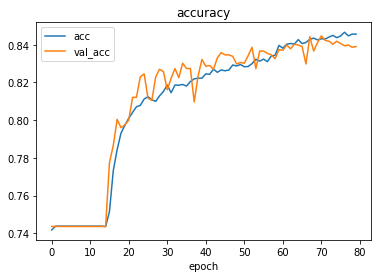

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

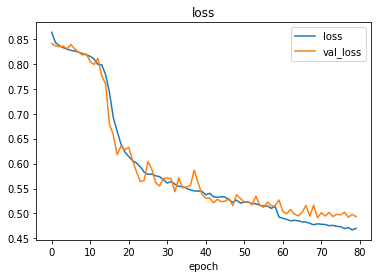

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

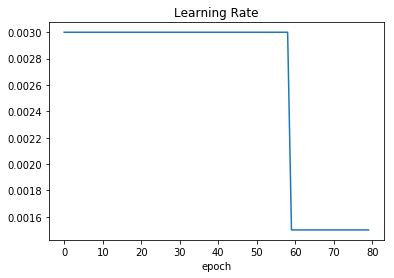

In [19]:
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.xlabel('epoch')
plt.show()

In [32]:
y_pred = model.predict_generator(validate_gen, len(validate_gen),verbose=1,workers=12)
y_pred = np.argmax(y_pred, axis=1)

71/71 [==============================] - 60s 843ms/step


In [33]:
y_pred

array([0, 2, 0, ..., 1, 2, 0])

In [34]:
print(len(y_pred))

2485


In [22]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]

y_true = flatten_list([np.argmax(y_true, axis=1) for x, y_true in validate_gen])

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

confusion_table = confusion_matrix(y_true, y_pred)
confusion_table

array([[1797,    7,   43,    0,    1],
       [ 125,   16,   36,    0,    0],
       [  91,   14,  251,    6,    3],
       [   7,    1,   31,   16,    3],
       [   3,    0,   19,    6,    9]])

In [23]:
import numpy as np
from sklearn import metrics
metrics.accuracy_score(y_pred,y_true)

0.8406438631790745

In [35]:
df_cmx = pd.DataFrame(confusion_table, index=[0, 1, 2, 3, 4], columns=[0, 1, 2, 3, 4])

plt.figure(figsize = (10,6))
sn.set(font_scale=1.5)
ax = sn.heatmap(df_cmx, annot=True, cmap='Oranges', fmt='g')
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
plt.show()

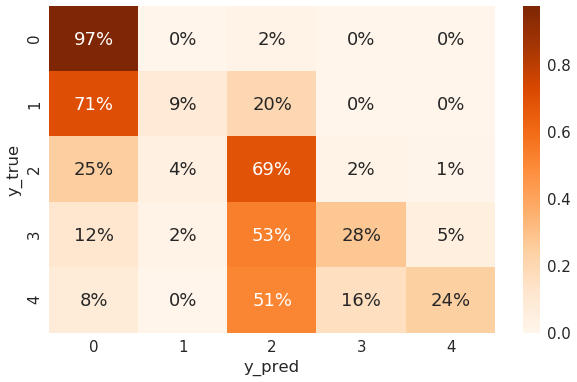

In [25]:
normalized_cf_matrix= confusion_table / confusion_table.sum(axis=1, keepdims=True)
df_cmx = pd.DataFrame(normalized_cf_matrix, index=[0, 1, 2, 3, 4], columns=[0, 1, 2, 3, 4])
plt.figure(figsize = (10,6))
sn.set(font_scale=1.5)
ax = sn.heatmap(df_cmx, annot=True, cmap='Oranges', fmt='.0%')
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
plt.show()

In [26]:
y_p=[]
y_t=[]
for var in (y_pred):
    if var>0:
        y_p.append(1)
    else:
        y_p.append(0)
for var in (y_true):
    if var>0:
        y_t.append(1)
    else:
        y_t.append(0)

In [27]:
c_table = confusion_matrix(y_t, y_p)
normalized_cf_matrix= c_table / c_table.sum(axis=1, keepdims=True)
df_cmx = pd.DataFrame(normalized_cf_matrix, index=[0, 1], columns=[0, 1])
plt.figure(figsize = (10,6))
sn.set(font_scale=1.5)
ax = sn.heatmap(df_cmx, annot=True, cmap='Oranges', fmt='.0%')
ax.set_ylabel('y_true')
ax.set_xlabel('y_pred')
plt.show()

In [29]:
m_temp = np.zeros((len(y_pred), 2))

for i in range(len(m_temp)):
    m_temp[i, 0] = i + 1
    m_temp[i, 1] = y_pred[i,0]
        
df_sample = pd.DataFrame(m_temp,columns = ['ImageId', 'Label']).astype(int)
    
del m_temp, i    

df_sample.to_csv("submission.csv", index = False)
return print("Submission saved to csv file.")

IndexError: too many indices for array